We import all the packages we need for this project

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np 
import csv 
import pandas as pd
import seaborn as sns
import warnings

from numpy.core.fromnumeric import mean
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# imports for feed-forward neural network
import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K


# Explanatory Data Analysis

After reading the file containing the Dataset we analyze rows and columns. Then we create an heatmap that shows us if there are any NULL values(0 in this case).
Then we check the type of variables we are dealing with.
We isolate a feature called "tokens_title" to create a boxplot that shows the behaviour of the outliers. 
We define then the 1st(0.10) and 3rd(0.90) quantile to remove the outliers and finally split our Dataset.

## General structure

In [ ]:
# read input CSV
df_raw = pd.read_csv('social_media_shares.csv')

In [ ]:
# analyze number of (rows, column)
df_raw.shape

(39644, 59)

In [ ]:
# analyze names of columns
df_raw.columns

Index(['tokens_title', 'tokens_content', 'unique_tokens', 'non_stop_words',
       'non_stop_unique_tokens', 'hrefs', 'self_refs', 'imgs', 'videos',
       'token_length', 'keywords', 'lifestyle', 'entertainment', 'bus',
       'socmed', 'tech', 'world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_shares', 'monday', 'tuesday', 'wednesday',
       'thursday', 'friday', 'saturday', 'sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'subjectivity',
       'sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
    

## Presence of null values

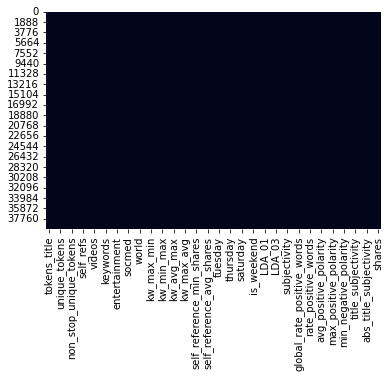

In [ ]:
# analyze null values with heatmap: null value will be shown as white dots
sns.heatmap(df_raw.isnull(), cbar=False) # NOTE: no null values

In [ ]:
# sum all null values
df_raw.isnull().sum().sum()

0


## Types of features


In [ ]:
# print types of variables. 
# As we can see, we do not have categorial variables, and all variables are numerical
df_raw.dtypes.astype(str).value_counts()

float64    34
int64      25
dtype: int64

## Outliers

In [ ]:
#BoxPlot
def plot_boxplot(df_raw, columns):
  df_raw.boxplot(column=columns)
  plt.grid(False)
  plt.show()

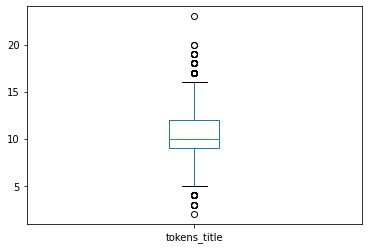

In [ ]:
plot_boxplot(df_raw, ["tokens_title"])

# Pre-Processing

In [ ]:
# removing null values
df_raw.dropna(inplace = True)

In [ ]:
def outliers(df_raw, ft):
  Q1 = df_raw[ft].quantile(0.10)
  Q3 = df_raw[ft].quantile(0.90)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  ls= df_raw.index[(df_raw[ft] < lower_bound) | (df_raw[ft] > upper_bound) ]
  return ls

In [ ]:
# create a list of index to drop because they contain outliers
#
# NOTE: possible different approach would be to swap the outlier with the mean value of the given column.
# Remove all the features with 0 1 values

index_list = []
skip_features = ['shares','unique_tokens','non_stop_words','non_stop_unique_tokens','lifestyle','entertainment','bus','socmed','tech','world','monday','tuesday','wednesday','thursday','friday','saturday','sunday','is_weekend']
for feature in df_raw.columns:
  if feature not in skip_features:
    index_list.extend(outliers(df_raw, feature))
print(index_list)

[39124, 1138, 1344, 1610, 1614, 1658, 1671, 1721, 1757, 1853, 2100, 2181, 2409, 2416, 2796, 2997, 3233, 3269, 3969, 4272, 4781, 5028, 5109, 5209, 5295, 5536, 5767, 5840, 5978, 6297, 7352, 8188, 8268, 8474, 8565, 8881, 8894, 9117, 9179, 9262, 9281, 9761, 9853, 9900, 10713, 11024, 11043, 11049, 11810, 11939, 12037, 12269, 12528, 12642, 12667, 12994, 13334, 13354, 13380, 13388, 13535, 13588, 13770, 13836, 13886, 13887, 13941, 14023, 14024, 14120, 14201, 14279, 14661, 14695, 14792, 14879, 14892, 14924, 14973, 15091, 15101, 15146, 15281, 15323, 15325, 15332, 15392, 15745, 15748, 15759, 15804, 16238, 16435, 16533, 16989, 17060, 17082, 17857, 17891, 17945, 18312, 18443, 18479, 18702, 18704, 18739, 18748, 19194, 19196, 19349, 19464, 19513, 19576, 19677, 19745, 19853, 20064, 20071, 20159, 20657, 20773, 20797, 20877, 20998, 21249, 21283, 21303, 21433, 21458, 21483, 21595, 21616, 21819, 21852, 21946, 21963, 22305, 22375, 22398, 22423, 22514, 22520, 22642, 22697, 22746, 22842, 23013, 23078, 23180,

In [ ]:
def remove(df_raw, ls):
  ls = sorted(set(ls))
  df_raw = df_raw.drop(ls)
  return df_raw

In [ ]:
df_cleaned = remove(df_raw, index_list)

In [ ]:
df_cleaned.shape

(20875, 59)

# Generating Dataset (Test+Train)

We generate a Train/Test Dataset allocating to the test part 25% of the Datase. we apply, then, a RobustScaler to fit and transform our train and test set.

In [ ]:
# creation of train/test split

X = df_cleaned.iloc[:, :-1]  # all columns exept last
# selecting the column to use as output
y = df_cleaned.iloc[:, -1]  # last column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (15656, 58)
X_test: (5219, 58)
y_train: (15656,)
y_test: (5219,)


In [ ]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model Selection

In [ ]:
# to ignore warnings during hyper-parameter tuning
warnings.filterwarnings("ignore", category=DeprecationWarning)

def get_best_hyperparameters(model, parameters, metrics, X_train, y_train):
  # Create the cross-validation grid with k=10
  grid = GridSearchCV(model, parameters, cv=10, scoring=metrics)

  # Search the grid using your training data
  grid.fit(X_train, y_train)

  # Return the best hyperparameters
  return grid.best_params_

# as a scoring measure we use 'neg_mean_squared_error', which means that the error is computed
# by taking the average of the squares between the predicted value and the expected value
# 
# Error = (sum (y_predicted - y_expected)^2) / n
# 
def evaluate_model(model, X_train, y_train, scoring="neg_mean_squared_error"):
  results = cross_val_score(model, X_train, y_train, scoring=scoring)
  return -results.mean()

We create a Validation Train/Test split on the previous Train/Test Dataset to apply our models with the default Hyperparameters.
Then we apply the Linear Regression, the Polynomial Regression and the Feed-Forward regression models with different hyperparameters each.
We choose there parameters based on tests we did with other hyperparameters and simply adding the ones that gave us the best results.
After that we do a final Train/Test regression for each models that gives as an output the MSE.

In [ ]:
# manual validation split
X_validation_train, X_validation, y_validation_train, y_validation = train_test_split(X_train, y_train, test_size=0.25)
print("X_validation_train:", X_validation_train.shape)
print("X_validation:", X_validation.shape)
print("y_validation_train:", y_validation_train.shape)
print("y_validation:", y_validation.shape)

X_validation_train: (11742, 58)
X_validation: (3914, 58)
y_validation_train: (11742,)
y_validation: (3914,)


In [ ]:
# linear regression with default hyperparameters and manual validation split
linear_regressor = LinearRegression()
linear_regressor.fit(X_validation_train, y_validation_train)
y_validation_pred = linear_regressor.predict(X_validation)

results = evaluate_model(linear_regressor, X_validation, y_validation)
print(results)

241969460.85625488


In [ ]:
# linear regression with kfold=10
linear_regressor = LinearRegression()
# fit_intercept: if False, intercept is set to 0, otherwise is computed
# positive: If True, coefficients are forced to be all positive 
hyper_parameters = {'fit_intercept':[True, False],'positive':[True, False]}
metrics = 'neg_mean_squared_error'
params = get_best_hyperparameters(linear_regressor, hyper_parameters, metrics, X_train, y_train)

In [ ]:
# final linear regression on train/test
linear_regressor = LinearRegression(fit_intercept=params['fit_intercept'], positive=params['positive'])
linear_regressor.fit(X_train, y_train)
results = evaluate_model(linear_regressor, X_test, y_test)
print(f"Linear regression MSE: {results}")

Linear regression MSE: 52184659.45909838


In [ ]:
# polynomial regression with default hyperparameters and manual validation split
polyreg=make_pipeline(PolynomialFeatures(),LinearRegression())
polyreg.fit(X_validation_train, y_validation_train)
results = evaluate_model(polyreg, X_validation, y_validation)
print(results)

225144302.56420732


In [ ]:
# polynomial regression with kfold = 10 and hyperparameter search
polyreg=make_pipeline(PolynomialFeatures(),LinearRegression())
polyreg.get_params().keys()

# polynomialfeatures__interaction_only: only interaction features are produced
# polynomialfeatures__include_bias: include a bias column, the feature in which all polynomial powers are zero
hyper_parameters = {'polynomialfeatures__interaction_only': [False, True], 'polynomialfeatures__include_bias': [False, True]}
metrics = 'neg_mean_squared_error'
get_best_hyperparameters(polyreg, hyper_parameters, metrics, X_train, y_train)

{'polynomialfeatures__include_bias': False,
 'polynomialfeatures__interaction_only': False}

In [ ]:
# final polynimal regression on train/test
polyreg=make_pipeline(PolynomialFeatures(interaction_only='False', include_bias='False'),LinearRegression())
polyreg.fit(X_train, y_train)
results = evaluate_model(polyreg, X_test, y_test)
print(f"Polynomial regression MSE: {results}")

Polynomial regression MSE: 88915310.01345773


In [ ]:
# definition of loss function
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(float(y_pred) - float(y_true)))

# neural network with default hyperparameters and manual validation split
number_of_features = 58

# feed forward neural network
nn = Sequential()
# input layer and first hidden layer. 
# Note the input_dim = 58, used to specify the number of inputs
nn.add(Dense(50, kernel_initializer = 'he_uniform', activation='relu', input_dim = number_of_features))
# other hidden layers
nn.add(Dense(25, kernel_initializer = 'he_uniform', activation='relu'))
# no need for activation funs in output layer: we have a regression problem.
# only 1 output node is needed
nn.add(Dense(1, kernel_initializer = 'he_uniform'))

nn.compile(loss=mean_squared_error, optimizer='Adamax')

model_history = nn.fit(X_validation_train, y_validation_train)

scores = nn.evaluate(X_validation, y_validation, verbose=0)
print(scores)

367/367 [==============================] - 1s 2ms/step - loss: 108470856.0000
115485888.0


In [ ]:
# neural network with kfold = 10 and hyperparameter search
def create_model():
  nn = Sequential()
  # input layer and first hidden layer
  nn.add(Dense(50, kernel_initializer = 'he_uniform', activation='relu', input_dim = number_of_features))
  # other hidden layers
  nn.add(Dense(25, kernel_initializer = 'he_uniform', activation='relu'))
  # no need for activation funs in output layer: we have a regression problem.
  nn.add(Dense(1, kernel_initializer = 'he_uniform'))
  nn.compile(loss=mean_squared_error, optimizer='Adamax')
  return nn

estimator = KerasRegressor(build_fn=create_model)
hyper_parameters = { 'epochs': [10,20,30] }
metrics = 'neg_mean_squared_error'
get_best_hyperparameters(estimator, hyper_parameters, metrics, X_train, y_train)

Epoch 1/10
441/441 [==============================] - 1s 2ms/step - loss: 67604312.0000
Epoch 2/10
441/441 [==============================] - 1s 2ms/step - loss: 67466840.0000
Epoch 3/10
441/441 [==============================] - 1s 2ms/step - loss: 67399664.0000
Epoch 4/10
441/441 [==============================] - 1s 2ms/step - loss: 67274040.0000
Epoch 5/10
441/441 [==============================] - 1s 2ms/step - loss: 67073836.0000
Epoch 6/10
441/441 [==============================] - 1s 2ms/step - loss: 66803976.0000
Epoch 7/10
441/441 [==============================] - 1s 2ms/step - loss: 66341556.0000
Epoch 8/10
441/441 [==============================] - 1s 2ms/step - loss: 65862432.0000
Epoch 9/10
441/441 [==============================] - 1s 2ms/step - loss: 65297188.0000
Epoch 10/10
49/49 [==============================] - 0s 1ms/step
Epoch 1/10
441/441 [==============================] - 1s 2ms/step - loss: 116698992.0000
Epoch 2/10
441/441 [==============================] - 

{'epochs': 30}

In [ ]:
# final neural network on train/test
nn = Sequential()
# input layer and first hidden layer
nn.add(Dense(50, kernel_initializer = 'he_uniform', activation='relu', input_dim = number_of_features))
# other hidden layers
nn.add(Dense(25, kernel_initializer = 'he_uniform', activation='relu'))
# no need for activation funs in output layer: we have a regression problem.
nn.add(Dense(1, kernel_initializer = 'he_uniform'))

nn.compile(loss=mean_squared_error, optimizer='Adamax')
model_history = nn.fit(X_train, y_train, epochs=20)
scores = nn.evaluate(X_test, y_test, verbose=0)
print(scores)

Epoch 1/20
490/490 [==============================] - 1s 2ms/step - loss: 115982560.0000
Epoch 2/20
490/490 [==============================] - 1s 2ms/step - loss: 110126568.0000
Epoch 3/20
490/490 [==============================] - 1s 2ms/step - loss: 109933656.0000
Epoch 4/20
490/490 [==============================] - 1s 2ms/step - loss: 109553808.0000
Epoch 5/20
490/490 [==============================] - 1s 2ms/step - loss: 109147352.0000
Epoch 6/20
490/490 [==============================] - 1s 2ms/step - loss: 108628776.0000
Epoch 7/20
490/490 [==============================] - 1s 2ms/step - loss: 107935496.0000
Epoch 8/20
490/490 [==============================] - 1s 2ms/step - loss: 107065040.0000
Epoch 9/20
490/490 [==============================] - 1s 2ms/step - loss: 106186032.0000
Epoch 10/20
490/490 [==============================] - 1s 2ms/step - loss: 105392024.0000
Epoch 11/20
490/490 [==============================] - 1s 2ms/step - loss: 104661368.0000
Epoch 12/20
490/490

# Final Model Performance

After checking the results of our models we create a subset of the 20 most relevant attributes to train again our model and check again the performance.
Ultimately we generated a scatterplot using the most relevant feature named 'kw_avg_avg' and comparing the shares expected with the shares predicted.

In [ ]:
# Mean-Squared-Error (MSE) on test set with random_state=42:
# - Linear Regression model: 52184659.45909838
# - Polynomial regression model: 88915310.01345773
# - Feed-Forward Neural Network model: 52145520.0
#
# Therefore the models with lower MSE are Linear Regression and Feed-Forward Neural Network

In [ ]:
# select a subset of the attributes retaining only the most relevant. 
# Train again your best model and compare the performances.


from sklearn.feature_selection import f_regression

X = df_cleaned.iloc[:, :-1]  # tutte le colonne tranne l'ultima
# Seleziona la colonna da utilizzare come output
y = df_cleaned.iloc[:, -1]  # ultima colonna

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# assigning f and p values to 2 separate arrays
f_val, p_val = f_regression(X_train,y_train)

# creating a dictionary from the arrays
feature_dict={'features':X_train.columns.tolist(),
              'f_scores':f_val.tolist()}

# creating a sorted dataframe from the dictionary
feature_df = pd.DataFrame(feature_dict).sort_values(by='f_scores', ascending=False).reset_index(drop=True)

# printing 20 features with the highest scores
most_significant_features = feature_df.iloc[:20,:]['features'].tolist() + ['shares']
print(most_significant_features)

In [ ]:
# Train again your model and check performance
new_df = df_cleaned[most_significant_features]
X = new_df.iloc[:, :-1]  # tutte le colonne tranne l'ultima
y = new_df.iloc[:, -1]  # ultima colonna

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

linear_regressor = LinearRegression(fit_intercept=params['fit_intercept'], positive=params['positive'])
linear_regressor.fit(X_train, y_train)
results = evaluate_model(linear_regressor, X_test, y_test)
print(f"Linear Regression MSE with top 20 feature: {results}")

X_train: (15656, 20)
X_test: (5219, 20)
y_train: (15656,)
y_test: (5219,)
Linear Regression MSE with top 20 feature: 222559148.98206106


X_train: (15656, 20)
X_test: (5219, 20)
y_train: (15656,)
y_test: (5219,)
5219
5219


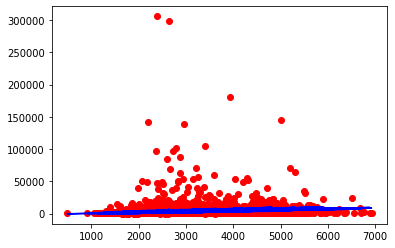

In [ ]:
# visualizing single feature effect on prediction of shares
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

linear_regressor = LinearRegression(fit_intercept='false', positive='false')
linear_regressor.fit(X_train, y_train)

feature = 'kw_avg_avg'

feature_values = list(X_test[feature])
shares_expected = list(y_test)
shares_predicted = list(linear_regressor.predict(X_test))

print(len(feature_values))
print(len(shares_predicted))

plt.scatter(feature_values, shares_expected, color = 'red')
plt.plot(feature_values, shares_predicted, color = 'blue')
plt.show()